# Single qubit gates in a lattice

In this notebook we show how to perform single qubit gates in a lattice of Rydberg Atoms

In [1]:
import tensorflow as tf

2024-04-15 17:29:32.885897: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 17:29:32.910236: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 17:29:33.052716: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-15 17:29:33.053581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 17:29:34.025650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
sim_res = 2e9
awg_res = 5e8

In [3]:
from qruise.toolset.libraries.rydberg.lattice import SquareLattice
r12 = 4.0
lattice = SquareLattice(n_side=2, r_interatomic=r12)
lattice.draw()

Create the Rydberg systems consisting of Rydberg atom components coupled via Van Der Walls interactions.

In [4]:
from qruise.toolset.libraries.rydberg.rydbergsystem import RydbergSystem
hilbert_dim = 3
ryd_system = RydbergSystem(lattice=lattice, hilbert_dim=hilbert_dim)

In [5]:
ryd_system.rydberg_atom_list

[RydbergAtom(name='0', detuning=0.000 2pi Hz),
 RydbergAtom(name='1', detuning=0.000 2pi Hz),
 RydbergAtom(name='2', detuning=0.000 2pi Hz),
 RydbergAtom(name='3', detuning=0.000 2pi Hz)]

In [6]:
import numpy as np
from qruise.toolset.objects import Quantity
phase_y = Quantity(value=0.5 * np.pi, unit="rads")
phase_x = Quantity(value=0.0, unit="rads")

In [7]:
for atom in ryd_system.rydberg_atom_list:
    name = atom.name
    ryd_system.add_drive(
    "amplitude-phase",
    f"rx{name}",
    channel="raman",
    connected=[name],
    phase=phase_x,
)
    ryd_system.add_drive(
    "amplitude-phase",
    f"ry{name}",
    channel="raman",
    connected=[name],
    phase=phase_y,
)
    ryd_system.add_drive(
        "amplitude-phase",
        f"rydbergx{name}",
        channel="rydberg",
        connected=[name],
        phase=phase_x,
    )


In [8]:
rabi_amplitude = 2.5e6 # MHz
t_pi = np.round(1 / (2 * rabi_amplitude) * 1e9) * 1e-9
t_pi_quantity = Quantity(value=t_pi, unit="s")

In [9]:
t_pi

2.0000000000000002e-07

Create a circuit using qiskit library

In [10]:
# Qiskit related modules
from qruise.qiskit.gates import RX90pGate, RY90pGate
from qiskit import QuantumCircuit

circuit = QuantumCircuit(4)
circuit.append(RX90pGate(), [0])
circuit.append(RY90pGate(), [1])
circuit.draw()

┌────────────┐
q_0: ┤ Rx90p(π/2) ├
     ├────────────┤
q_1: ┤ Ry90p(π/2) ├
     └────────────┘
q_2: ──────────────
                   
q_3: ──────────────

In [11]:
for c in circuit:
    print(c.operation)
    print(c.qubits[0]._index)

Instruction(name='rx90p', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
0
Instruction(name='ry90p', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
1


In [12]:
from qruise_utils import create_instructions, name_rx_gate, name_ry_gate, name_cz_gate

In [13]:
gates_list = create_instructions(rydberg_system=ryd_system, circuit=circuit, rabi_amplitude=rabi_amplitude)

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: rx. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: 1.570796. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: 0. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: ry. Use set_ideal() explicitly.

/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/signal/gates.py:211: UserWarning:

No ideal gate found for gate: 1. Use set_ideal() explicitly.



In [14]:
gates_list

[Instruction(rx_1.570796_0[0]), Instruction(ry_1.570796_1[1])]

In [15]:
ryd_system.create_model()

In [16]:
ryd_system.create_experiment()

I am in invalidate_propagators


In [17]:
sequence = [gate.get_key() for gate in gates_list]

In [18]:
sequence

['rx_1.570796_0[0]', 'ry_1.570796_1[1]']

In [19]:
ryd_system.experiment.draw_dynamics(sequence=sequence, state=ryd_system.model.get_init_state())

Compute the final state with qiskit

In [20]:
from qiskit.quantum_info import Statevector
ideal_results = Statevector.from_instruction(circuit).probabilities_dict()
print(ideal_results)

{'0000': 0.2500000000000001, '0001': 0.25, '0010': 0.25, '0011': 0.2499999999999999}


Due to the flip_label qiskit convention, the results seem wrong bu they are correct.

Now we simulate the same circuit with the qruise_backend

In [21]:
import copy
qruise_experiment = copy.deepcopy(ryd_system.experiment)

In [22]:
from qruise.toolset.qiskit import QruiseProvider
from qruise.toolset.libraries.rydberg import RydbergAtom


In [23]:
qruise_provider = QruiseProvider()
qruise_backend = qruise_provider.get_backend("qruise_qasm_rydberg_simulator")
# Set qubit type to Rydberg atom
qruise_backend.qubit_type = RydbergAtom
qruise_backend.set_qruise_experiment(qruise_experiment)

I am in invalidate_propagators
I am in invalidate_propagators
I am in invalidate_propagators


/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/experiment.py:153: UserWarning:

Using default simulation resolution in experiment, make sure this is what you expect (or you have set sim_res in the Instructions)



Out {'gate': 'rx', 'name': 'rx_1.570796_0[0]', 'parameters': [{'date': '2024-04-15T17:29:38.899825', 'name': 'gate_error', 'unit': '', 'value': 0.0}, {'date': '2024-04-15T17:29:38.899825', 'name': 'gate_duration', 'unit': 's', 'value': 1e-07}], 'qubits': [0]}
Out {'gate': 'ry', 'name': 'ry_1.570796_1[1]', 'parameters': [{'date': '2024-04-15T17:29:38.899825', 'name': 'gate_error', 'unit': '', 'value': 0.0}, {'date': '2024-04-15T17:29:38.899825', 'name': 'gate_duration', 'unit': 's', 'value': 1e-07}], 'qubits': [1]}
Out {'gate': 'rz', 'name': 'rz[0]', 'parameters': [{'date': '2024-04-15T17:29:38.899825', 'name': 'gate_error', 'unit': '', 'value': 0.0}, {'date': '2024-04-15T17:29:38.899825', 'name': 'gate_duration', 'unit': 's', 'value': 0.0}], 'qubits': [0]}
Out {'gate': 'rz', 'name': 'rz[1]', 'parameters': [{'date': '2024-04-15T17:29:38.899825', 'name': 'gate_error', 'unit': '', 'value': 0.0}, {'date': '2024-04-15T17:29:38.899825', 'name': 'gate_duration', 'unit': 's', 'value': 0.0}], '

In [24]:
def state_transform_function() -> callable:
    def state_transform(
        state: tf.Tensor, gate_dict: dict, reshape_after: bool, reshape_before: bool
    ):
        # Gate dict name
        gate_name = gate_dict["name"]
        if gate_name == "cz":
            atom1 = gate_dict["qubits"][0]
            atom2 = gate_dict["qubits"][1]
            gate_dict["name"] = name_cz_gate(atom1, atom2)
            for pulse_index in [1, 2, 3]:
                reshape_after = (
                None if reshape_after is None and pulse_index == 3 else False
                )
                state = qruise_experiment.lookup_propagator(
                    **gate_dict,
                    compute=False,
                    gate_index=f"_{str(pulse_index)}",
                ).propagate_state(
                    state, reshape_after=reshape_after, reshape_before=reshape_before
                )
                reshape_before = False
        else:
            print("Gate dict", gate_dict)
            angle = gate_dict["params"][0]
            atom = gate_dict["qubits"][0]
            gate_dict["name"] = name_rx_gate(angle, atom) if "rx" in gate_name else name_ry_gate(angle, atom)
            state = qruise_experiment.lookup_propagator(
                **gate_dict,
                compute=False,
            ).propagate_state(
                state, reshape_after=reshape_after, reshape_before=reshape_before
            )
        return state

    return state_transform

In [25]:
qruise_backend._state_propagation_function = state_transform_function()

In [26]:
circuit.measure_all()

In [27]:
circuit.draw()

┌────────────┐ ░ ┌─┐         
   q_0: ┤ Rx90p(π/2) ├─░─┤M├─────────
        ├────────────┤ ░ └╥┘┌─┐      
   q_1: ┤ Ry90p(π/2) ├─░──╫─┤M├──────
        └────────────┘ ░  ║ └╥┘┌─┐   
   q_2: ───────────────░──╫──╫─┤M├───
                       ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────░──╫──╫──╫─┤M├
                       ░  ║  ║  ║ └╥┘
meas: 4/══════════════════╩══╩══╩══╩═
                          0  1  2  3

In [28]:
results = qruise_backend.run(circuit, shots=1000, memory=True)

Gate dict {'name': 'rx90p', 'params': [1.5707963267948966], 'qubits': [0]}
Is propagator None? True


/home/marco/GitHub_Qruise/qruise-toolset/src/qruise/toolset/qiskit/backends.py:336: UserWarning:

The following operations are not supported yet: ['measure', 'barrier']



Gate dict {'name': 'ry90p', 'params': [1.5707963267948966], 'qubits': [1]}
Is propagator None? False
Meas_index [3, 4, 5, 6]
Pops array [0.25 0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.25
 0.   0.   0.   0.   0.   0.   0.   0.   0.25 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
Inside _generate_shot_readout
Qruise labels ((0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 0, 2), (0, 1, 1, 0), (0, 1, 1, 1), (0, 1, 1, 2), (0, 1, 2, 0), (0, 1, 2, 1), (0, 1, 2, 2), (0, 2, 0, 0), (0, 2, 0, 1), (0, 2, 0, 2), (0, 2, 1, 0), (0, 2, 1, 1), (0, 2, 1, 2), (0, 2, 2, 0), (0, 2, 2, 1), (0, 2, 2, 2), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 0,

In [29]:
any(np.asarray((0,0,0))>1)

False

In [30]:
results.result().data()

{'counts': {'0x0': 259,
  '0x8': 0,
  '0x4': 0,
  '0xc': 0,
  '0x2': 258,
  '0xa': 0,
  '0x6': 0,
  '0xe': 0,
  '0x1': 250,
  '0x9': 0,
  '0x5': 0,
  '0xd': 0,
  '0x3': 233,
  '0xb': 0,
  '0x7': 0,
  '0xf': 0},
 'state_pops': {'(0, 0, 0, 0)': 0.24999999999999523,
  '(0, 0, 0, 1)': 0.0,
  '(0, 0, 0, 2)': 0.0,
  '(0, 0, 1, 0)': 0.0,
  '(0, 0, 1, 1)': 0.0,
  '(0, 0, 1, 2)': 0.0,
  '(0, 0, 2, 0)': 0.0,
  '(0, 0, 2, 1)': 0.0,
  '(0, 0, 2, 2)': 0.0,
  '(0, 1, 0, 0)': 0.24999999999999523,
  '(0, 1, 0, 1)': 0.0,
  '(0, 1, 0, 2)': 0.0,
  '(0, 1, 1, 0)': 0.0,
  '(0, 1, 1, 1)': 0.0,
  '(0, 1, 1, 2)': 0.0,
  '(0, 1, 2, 0)': 0.0,
  '(0, 1, 2, 1)': 0.0,
  '(0, 1, 2, 2)': 0.0,
  '(0, 2, 0, 0)': 0.0,
  '(0, 2, 0, 1)': 0.0,
  '(0, 2, 0, 2)': 0.0,
  '(0, 2, 1, 0)': 0.0,
  '(0, 2, 1, 1)': 0.0,
  '(0, 2, 1, 2)': 0.0,
  '(0, 2, 2, 0)': 0.0,
  '(0, 2, 2, 1)': 0.0,
  '(0, 2, 2, 2)': 0.0,
  '(1, 0, 0, 0)': 0.24999999999999523,
  '(1, 0, 0, 1)': 0.0,
  '(1, 0, 0, 2)': 0.0,
  '(1, 0, 1, 0)': 0.0,
  '(1, 0, 1, 1

In [31]:
[label for label in qruise_experiment.pmap.model.index_labels if all(np.asarray(label) < 2)]

[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 1, 0),
 (1, 0, 1, 1),
 (1, 1, 0, 0),
 (1, 1, 0, 1),
 (1, 1, 1, 0),
 (1, 1, 1, 1)]

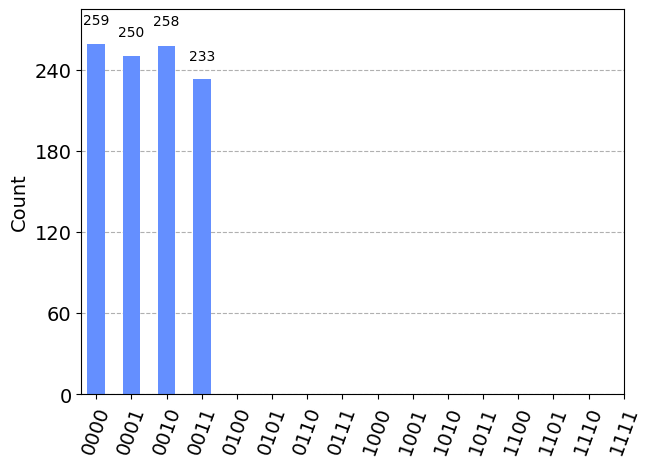

In [32]:
from qiskit.visualization import plot_histogram

plot_histogram(results.result().get_counts())

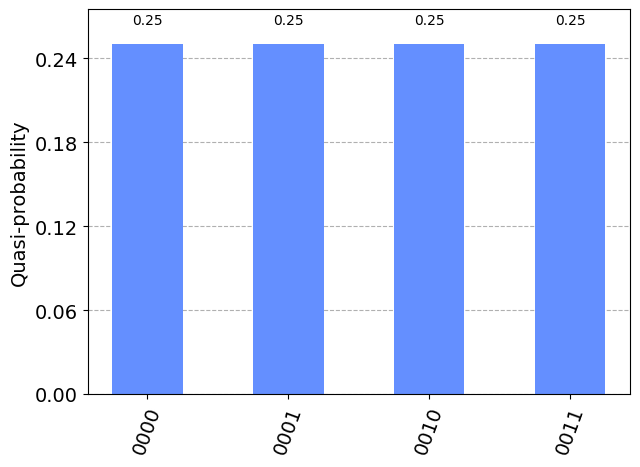

In [33]:
plot_histogram(ideal_results)